**References**
- [MABe Nearest Neighbors: The Original ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/mabe-nearest-neighbors-the-original)
- [MABe EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/mabe-eda-which-makes-sense)
- [MABe Validated baseline without machine learning](https://www.kaggle.com/code/ambrosm/mabe-validated-baseline-without-machine-learning)
- [Squeeze GBT](https://www.kaggle.com/code/cody11null/squeeze-gbt)

## Imports and configs

In [1]:
!pip install koolbox --no-index --find-links=/kaggle/input/koolbox-offline

Looking in links: /kaggle/input/koolbox-offline
Processing /kaggle/input/koolbox-offline/koolbox-0.1.3-py3-none-any.whl
Processing /kaggle/input/koolbox-offline/scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (from koolbox)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [2]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from sklearn.base import clone
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
from koolbox import Trainer
import lightgbm as lgb
import numpy as np
import itertools
import warnings
import optuna
import joblib
import glob
import gc
from scipy.ndimage import label as scipy_label


optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

In [3]:
import os
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42)

In [4]:
import torch

# Kiểm tra GPU khả dụng
USE_GPU = torch.cuda.is_available()

if USE_GPU:
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    # Cấu hình cho XGBoost sử dụng GPU
    XGB_TREE_METHOD = 'gpu_hist' 
    XGB_DEVICE = 'cuda'
else:
    print("GPU not available, using CPU.")
    XGB_TREE_METHOD = 'hist'
    XGB_DEVICE = 'cpu'

GPU not available, using CPU.


In [5]:
class CFG:
    train_path = "/kaggle/input/MABe-mouse-behavior-detection/train.csv"
    test_path = "/kaggle/input/MABe-mouse-behavior-detection/test.csv"
    train_annotation_path = "/kaggle/input/MABe-mouse-behavior-detection/train_annotation"
    train_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/train_tracking"
    test_tracking_path = "/kaggle/input/MABe-mouse-behavior-detection/test_tracking"

    model_path = "."
    model_name = "lgbm"
    
    mode = "validate"
    # mode = "submit"

    n_splits=2

    cv = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)

    model = lgb.LGBMClassifier(
        verbosity=-1,         
        random_state=43,
        n_estimators=350, 
        learning_rate=0.15, 
        max_depth=8,
        min_child_weight=10, 
        subsample=0.8, 
        colsample_bytree=0.8,
        reg_alpha=0.07,
        reg_lambda=0.05,
        n_jobs=-1,
        device_type='cpu' 
    )

## Competition Metric (F-Beta Score)

In [6]:
"""F Beta customized for the data format of the MABe challenge."""

import json

from collections import defaultdict

import pandas as pd
import polars as pl


class HostVisibleError(Exception):
    pass


def single_lab_f1(lab_solution: pl.DataFrame, lab_submission: pl.DataFrame, beta: float = 1) -> float:
    label_frames: defaultdict[str, set[int]] = defaultdict(set)
    prediction_frames: defaultdict[str, set[int]] = defaultdict(set)

    for row in lab_solution.to_dicts():
        label_frames[row['label_key']].update(range(row['start_frame'], row['stop_frame']))

    for video in lab_solution['video_id'].unique():
        active_labels: str = lab_solution.filter(pl.col('video_id') == video)['behaviors_labeled'].first()  # ty: ignore
        active_labels: set[str] = set(json.loads(active_labels))
        predicted_mouse_pairs: defaultdict[str, set[int]] = defaultdict(set)

        for row in lab_submission.filter(pl.col('video_id') == video).to_dicts():
            # Since the labels are sparse, we can't evaluate prediction keys not in the active labels.
            if ','.join([str(row['agent_id']), str(row['target_id']), row['action']]) not in active_labels:
                continue

            new_frames = set(range(row['start_frame'], row['stop_frame']))
            # Ignore truly redundant predictions.
            new_frames = new_frames.difference(prediction_frames[row['prediction_key']])
            prediction_pair = ','.join([str(row['agent_id']), str(row['target_id'])])
            if predicted_mouse_pairs[prediction_pair].intersection(new_frames):
                # A single agent can have multiple targets per frame (ex: evading all other mice) but only one action per target per frame.
                raise HostVisibleError('Multiple predictions for the same frame from one agent/target pair')
            prediction_frames[row['prediction_key']].update(new_frames)
            predicted_mouse_pairs[prediction_pair].update(new_frames)

    tps = defaultdict(int)
    fns = defaultdict(int)
    fps = defaultdict(int)
    for key, pred_frames in prediction_frames.items():
        action = key.split('_')[-1]
        matched_label_frames = label_frames[key]
        tps[action] += len(pred_frames.intersection(matched_label_frames))
        fns[action] += len(matched_label_frames.difference(pred_frames))
        fps[action] += len(pred_frames.difference(matched_label_frames))

    distinct_actions = set()
    for key, frames in label_frames.items():
        action = key.split('_')[-1]
        distinct_actions.add(action)
        if key not in prediction_frames:
            fns[action] += len(frames)

    action_f1s = []
    for action in distinct_actions:
        if tps[action] + fns[action] + fps[action] == 0:
            action_f1s.append(0)
        else:
            action_f1s.append((1 + beta**2) * tps[action] / ((1 + beta**2) * tps[action] + beta**2 * fns[action] + fps[action]))
    return sum(action_f1s) / len(action_f1s)


def mouse_fbeta(solution: pd.DataFrame, submission: pd.DataFrame, beta: float = 1) -> float:
   
    if len(solution) == 0 or len(submission) == 0:
        raise ValueError('Missing solution or submission data')

    expected_cols = ['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']

    for col in expected_cols:
        if col not in solution.columns:
            raise ValueError(f'Solution is missing column {col}')
        if col not in submission.columns:
            raise ValueError(f'Submission is missing column {col}')

    solution: pl.DataFrame = pl.DataFrame(solution)
    submission: pl.DataFrame = pl.DataFrame(submission)
    assert (solution['start_frame'] <= solution['stop_frame']).all()
    assert (submission['start_frame'] <= submission['stop_frame']).all()
    solution_videos = set(solution['video_id'].unique())
    # Need to align based on video IDs as we can't rely on the row IDs for handling public/private splits.
    submission = submission.filter(pl.col('video_id').is_in(solution_videos))

    solution = solution.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('label_key'),
    )
    submission = submission.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('prediction_key'),
    )

    lab_scores = []
    for lab in solution['lab_id'].unique():
        lab_solution = solution.filter(pl.col('lab_id') == lab).clone()
        lab_videos = set(lab_solution['video_id'].unique())
        lab_submission = submission.filter(pl.col('video_id').is_in(lab_videos)).clone()
        lab_scores.append(single_lab_f1(lab_solution, lab_submission, beta=beta))

    return sum(lab_scores) / len(lab_scores)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, beta: float = 1) -> float:
    """
    F1 score for the MABe Challenge
    """
    solution = solution.drop(row_id_column_name, axis='columns', errors='ignore')
    submission = submission.drop(row_id_column_name, axis='columns', errors='ignore')
    return mouse_fbeta(solution, submission, beta=beta)

## Data loading and preprocessing

In [7]:
train = pd.read_csv(CFG.train_path)
train['n_mice'] = 4 - train[['mouse1_strain', 'mouse2_strain', 'mouse3_strain', 'mouse4_strain']].isna().sum(axis=1)
train_without_mabe22 = train.query("~lab_id.str.startswith('MABe22_')")

test = pd.read_csv(CFG.test_path)

In [8]:
body_parts_tracked_list = list(np.unique(train.body_parts_tracked))

## Creating solution data

In [9]:
# Hàm này chỉ lấy vid được annotated

def create_solution_df(dataset):
    solution = []
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
    
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'): 
            continue
        
        video_id = row['video_id']
        path = f"{CFG.train_annotation_path}/{lab_id}/{video_id}.parquet"
        try:
            annot = pd.read_parquet(path)
        except FileNotFoundError:
            continue
    
        annot['lab_id'] = lab_id
        annot['video_id'] = video_id
        annot['behaviors_labeled'] = row['behaviors_labeled']
        annot['target_id'] = np.where(annot.target_id != annot.agent_id, annot['target_id'].apply(lambda s: f"mouse{s}"), 'self')
        annot['agent_id'] = annot['agent_id'].apply(lambda s: f"mouse{s}")
        solution.append(annot)
    
    solution = pd.concat(solution)
    
    return solution

if CFG.mode == 'validate':
    solution = create_solution_df(train_without_mabe22)

  0%|          | 0/863 [00:00<?, ?it/s]

## Data generator

In [10]:
drop_body_parts = [
    'headpiece_bottombackleft', 'headpiece_bottombackright', 
    'headpiece_bottomfrontleft', 'headpiece_bottomfrontright', 
    'headpiece_topbackleft', 'headpiece_topbackright', 
    'headpiece_topfrontleft', 'headpiece_topfrontright', 
    'spine_1', 'spine_2', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint'
]

def generate_mouse_data(dataset, traintest, traintest_directory=None, 
                       generate_single=True, generate_pair=True):
    
    if traintest_directory is None:
        traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"
        
    for _, row in dataset.iterrows():
        lab_id = row.lab_id
        if lab_id.startswith('MABe22') or type(row.behaviors_labeled) != str: 
            continue
        
        video_id = row.video_id
        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        vid = pd.read_parquet(path)
        
        if len(np.unique(vid.bodypart)) > 5:
            vid = vid.query("~ bodypart.isin(@drop_body_parts)")
            
        pvid = vid.pivot(columns=['mouse_id', 'bodypart'], index='video_frame', values=['x', 'y'])
        
        del vid
        gc.collect()
        
        pvid = pvid.reorder_levels([1, 2, 0], axis=1).T.sort_index().T
        pvid /= row.pix_per_cm_approx

        vid_behaviors = json.loads(row.behaviors_labeled)
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
        
        if traintest == 'train':
            try:
                annot = pd.read_parquet(path.replace('train_tracking', 'train_annotation'))
            except FileNotFoundError:
                continue

        if generate_single:
            vid_behaviors_subset = vid_behaviors.query("target == 'self'")
            for mouse_id_str in np.unique(vid_behaviors_subset.agent):
                try:
                    mouse_id = int(mouse_id_str[-1])
                    vid_agent_actions = np.unique(vid_behaviors_subset.query("agent == @mouse_id_str").action)
                    single_mouse = pvid.loc[:, mouse_id]
                    single_mouse_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': mouse_id_str,
                        'target_id': 'self',
                        'video_frame': single_mouse.index
                    })
                    if traintest == 'train':
                        single_mouse_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=single_mouse.index)
                        annot_subset = annot.query("(agent_id == @mouse_id) & (target_id == @mouse_id)")
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            single_mouse_label.loc[annot_row['start_frame']:annot_row['stop_frame'], annot_row.action] = 1.0
                        yield 'single', single_mouse, single_mouse_meta, single_mouse_label
                    else:
                        yield 'single', single_mouse, single_mouse_meta, vid_agent_actions
                except KeyError:
                    pass

        if generate_pair:
            vid_behaviors_subset = vid_behaviors.query("target != 'self'")
            if len(vid_behaviors_subset) > 0:
                for agent, target in itertools.permutations(np.unique(pvid.columns.get_level_values('mouse_id')), 2):
                    agent_str = f"mouse{agent}"
                    target_str = f"mouse{target}"
                    vid_agent_actions = np.unique(vid_behaviors_subset.query("(agent == @agent_str) & (target == @target_str)").action)
                    mouse_pair = pd.concat([pvid[agent], pvid[target]], axis=1, keys=['A', 'B'])
                    mouse_pair_meta = pd.DataFrame({
                        'video_id': video_id,
                        'agent_id': agent_str,
                        'target_id': target_str,
                        'video_frame': mouse_pair.index,
                        'video_frame': mouse_pair.index
                    })
                    if traintest == 'train':
                        mouse_pair_label = pd.DataFrame(0.0, columns=vid_agent_actions, index=mouse_pair.index)
                        annot_subset = annot.query("(agent_id == @agent) & (target_id == @target)")
                        for i in range(len(annot_subset)):
                            annot_row = annot_subset.iloc[i]
                            mouse_pair_label.loc[annot_row['start_frame']:annot_row['stop_frame'], annot_row.action] = 1.0
                        yield 'pair', mouse_pair, mouse_pair_meta, mouse_pair_label
                    else:
                        yield 'pair', mouse_pair, mouse_pair_meta, vid_agent_actions

## Transforming coordinates

In [11]:
def safe_rolling(series, window, func, min_periods=None):
    if min_periods is None:
        min_periods = max(1, window // 4)
    return series.rolling(window, min_periods=min_periods, center=True).apply(func, raw=True)

def _scale(n_frames_at_30fps, fps, ref=30.0):
    return max(1, int(round(n_frames_at_30fps * float(fps) / ref)))

def _scale_signed(n_frames_at_30fps, fps, ref=30.0):
    if n_frames_at_30fps == 0:
        return 0
    s = 1 if n_frames_at_30fps > 0 else -1
    mag = max(1, int(round(abs(n_frames_at_30fps) * float(fps) / ref)))
    return s * mag

def _fps_from_meta(meta_df, fallback_lookup, default_fps=30.0):
    if 'frames_per_second' in meta_df.columns and pd.notnull(meta_df['frames_per_second']).any():
        return float(meta_df['frames_per_second'].iloc[0])
    vid = meta_df['video_id'].iloc[0]
    return float(fallback_lookup.get(vid, default_fps))

def _speed(cx: pd.Series, cy: pd.Series, fps: float) -> pd.Series:
    return np.hypot(cx.diff(), cy.diff()).fillna(0.0) * float(fps)

def _roll_future_mean(s: pd.Series, w: int, min_p: int = 1) -> pd.Series:
    # mean over [t, t+w-1]
    return s.iloc[::-1].rolling(w, min_periods=min_p).mean().iloc[::-1]

def _roll_future_var(s: pd.Series, w: int, min_p: int = 2) -> pd.Series:
    # var over [t, t+w-1]
    return s.iloc[::-1].rolling(w, min_periods=min_p).var().iloc[::-1]

In [12]:
def add_curvature_features(X, center_x, center_y, fps):
    """Add curvature (trajectory bending) and turn rate features"""
    vel_x = center_x.diff()
    vel_y = center_y.diff()
    acc_x = vel_x.diff()    # acceleration
    acc_y = vel_y.diff()    

    # Curvature = |v × a| / |v|^3
    #  độ cong chuyển động
    cross_prod = vel_x * acc_y - vel_y * acc_x
    vel_mag = np.sqrt(vel_x**2 + vel_y**2)
    curvature = np.abs(cross_prod) / (vel_mag**3 + 1e-6)

    for w in [25, 50, 75]:
        ws = _scale(w, fps)
        X[f'curv_mean_{w}'] = curvature.rolling(ws, min_periods=max(1, ws // 5)).mean()

    # Turn rate (angular velocity)
    angle = np.arctan2(vel_y, vel_x)
    angle_change = np.abs(angle.diff())
    w = 30
    ws = _scale(w, fps)
    X[f'turn_rate_{w}'] = angle_change.rolling(ws, min_periods=max(1, ws // 5)).sum()
    # thay đổi góc. sum là kiểu tổng số rad đã xoay trong thời gian đó

    return X

In [13]:
def add_multiscale_features(X, center_x, center_y, fps):
    """Analyze speed at multiple time scales"""
    # nhân thêm fps để đổi từ pixel/frame thành đơn vị pixel/s
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)

    scales = [20, 40, 60, 80]
    for scale in scales:
        ws = _scale(scale, fps)
        if len(speed) >= ws:
            X[f'sp_m{scale}'] = speed.rolling(ws, min_periods=max(1, ws // 4)).mean()
            X[f'sp_s{scale}'] = speed.rolling(ws, min_periods=max(1, ws // 4)).std()

    # Speed ratio (short-term vs long-term)
    if len(scales) >= 2 and f'sp_m{scales[0]}' in X.columns and f'sp_m{scales[-1]}' in X.columns:
        # nếu ratio > 1 -> tăng tốc đột ngột, còn không thì dạng giảm tốc
        X['sp_ratio'] = X[f'sp_m{scales[0]}'] / (X[f'sp_m{scales[-1]}'] + 1e-6)

    return X

In [14]:
def add_state_features(X, center_x, center_y, fps):
    """Model movement states (immobile → slow → medium → fast)"""
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    w_ma = _scale(15, fps)
    speed_ma = speed.rolling(w_ma, min_periods=max(1, w_ma // 3)).mean()

    try:
        # Bin speeds into 4 states
        bins = [-np.inf, 0.5 * fps, 2.0 * fps, 5.0 * fps, np.inf]
        speed_states = pd.cut(speed_ma, bins=bins, labels=[0, 1, 2, 3]).astype(float)

        """
        df = pd.DataFrame({'Điểm': [45, 78, 92, 55, 88, 60, 70]})

        # 2. Định nghĩa các bins và labels
        bins = [0, 60, 75, 90, 100]
        labels = ['Dưới TB', 'Trung bình', 'Khá', 'Giỏi']

        # 3. Áp dụng pd.cut
        df['Xếp loại'] = pd.cut(df['Điểm'], bins=bins, labels=labels, right=False) # right=False: khoảng [a, b)

        print(df)
            Điểm Xếp loại
        0    45  Dưới TB
        1    78     Khá
        2    92    Giỏi
        3    55  Dưới TB
        4    88     Khá
        5    60  Dưới TB
        6    70 Trung bình
        """

        for window in [20, 40, 60, 80]:
            ws = _scale(window, fps)
            if len(speed_states) >= ws:
                # tính tần suất xuất hiện của mỗi trạng thái
                for state in [0, 1, 2, 3]:
                    X[f's{state}_{window}'] = (
                        (speed_states == state).astype(float)
                        .rolling(ws, min_periods=max(1, ws // 5)).mean()
                    )
                # số lần đổi trạng thái
                state_changes = (speed_states != speed_states.shift(1)).astype(float)
                X[f'trans_{window}'] = state_changes.rolling(ws, min_periods=max(1, ws // 5)).sum()
    except Exception:
        pass

    return X

In [15]:
def add_longrange_features(X, center_x, center_y, fps):
    """Long-range rolling means, EMA, and percentile ranks"""
    # Long-range rolling means
    for window in [30, 60, 120]:
        ws = _scale(window, fps)
        if len(center_x) >= ws:
            X[f'x_ml{window}'] = center_x.rolling(ws, min_periods=max(5, ws // 6)).mean()
            X[f'y_ml{window}'] = center_y.rolling(ws, min_periods=max(5, ws // 6)).mean()

    # Exponential moving averages
    for span in [30, 60, 120]:
        s = _scale(span, fps)
        X[f'x_e{span}'] = center_x.ewm(span=s, min_periods=1).mean()
        X[f'y_e{span}'] = center_y.ewm(span=s, min_periods=1).mean()

    # Speed percentile ranks
    speed = np.sqrt(center_x.diff()**2 + center_y.diff()**2) * float(fps)
    for window in [30, 60, 120]:
        ws = _scale(window, fps)
        if len(speed) >= ws:
            X[f'sp_pct{window}'] = speed.rolling(ws, min_periods=max(5, ws // 6)).rank(pct=True)
        # Tốc độ hiện tại của vật thể cao hơn 
        # bao nhiêu phần trăm của các tốc độ mà nó đã từng đạt được trong $X$ giây vừa qua?

    return X

In [16]:
def add_interaction_features(X, mouse_pair, avail_A, avail_B, fps):
    """Advanced interaction features for pairs (leading, chasing, etc.)"""
    if 'body_center' not in avail_A or 'body_center' not in avail_B:
        return X

    rel_x = mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x']
    rel_y = mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y']
    rel_dist = np.sqrt(rel_x**2 + rel_y**2)

    A_vx = mouse_pair['A']['body_center']['x'].diff()
    A_vy = mouse_pair['A']['body_center']['y'].diff()
    B_vx = mouse_pair['B']['body_center']['x'].diff()
    B_vy = mouse_pair['B']['body_center']['y'].diff()

    # Lead = 1: Con chuột đó đang di chuyển thẳng về phía đối phương.
    # Lead = -1: Con chuột đó đang di chuyển thẳng ra xa đối phương.
    # Lead = 0: Di chuyển vuông góc với đối phương
    A_lead = (A_vx * rel_x + A_vy * rel_y) / (np.sqrt(A_vx**2 + A_vy**2) * rel_dist + 1e-6)
    B_lead = (B_vx * (-rel_x) + B_vy * (-rel_y)) / (np.sqrt(B_vx**2 + B_vy**2) * rel_dist + 1e-6)

    for window in [30, 60]:
        ws = _scale(window, fps)
        X[f'A_ld{window}'] = A_lead.rolling(ws, min_periods=max(1, ws // 6)).mean()
        X[f'B_ld{window}'] = B_lead.rolling(ws, min_periods=max(1, ws // 6)).mean()

    # Chase behavior (approach rate * B_lead)
    approach = -rel_dist.diff()
    chase = approach * B_lead
    # | approach | B_lead | chase     | Ý nghĩa vật lý                             |
    # | -------- | ------ | --------- | ------------------------------------------ |
    # | +        | +      | + lớn     | B đang đuổi theo A thật sự                 |
    # | +        | -      | -         | Khoảng cách giảm nhưng B không hướng vào A |
    # | -        | +      | -         | B hướng vào A nhưng khoảng cách vẫn tăng   |
    # | -        | -      | +         | Cả hai đều rời xa                          |
    # | ≈ 0      | bất kỳ | ≈ 0       | Không có tương tác rõ ràng                 |

    w = 30
    ws = _scale(w, fps)
    X[f'chase_{w}'] = chase.rolling(ws, min_periods=max(1, ws // 6)).mean()

    # Speed correlation
    for window in [60, 120]:
        ws = _scale(window, fps)
        A_sp = np.sqrt(A_vx**2 + A_vy**2)
        B_sp = np.sqrt(B_vx**2 + B_vy**2)
        X[f'sp_cor{window}'] = A_sp.rolling(ws, min_periods=max(1, ws // 6)).corr(B_sp)

    return X

In [17]:
def add_groom_microfeatures(X, df, fps):
    parts = df.columns.get_level_values(0)
    if 'body_center' not in parts or 'nose' not in parts:
        return X

    cx = df['body_center']['x']; cy = df['body_center']['y']
    nx = df['nose']['x']; ny = df['nose']['y']

    # Tốc độ
    cs = (np.sqrt(cx.diff()**2 + cy.diff()**2) * float(fps)).fillna(0)
    ns = (np.sqrt(nx.diff()**2 + ny.diff()**2) * float(fps)).fillna(0)

    w30 = _scale(30, fps)
    # rate tốc độ mũi / tốc độ thân (Đầu di chuyển nhiều trong khi thân đứng yên -> grooming)
    X['head_body_decouple'] = (ns / (cs + 1e-3)).clip(0, 10).rolling(w30, min_periods=max(1, w30//3)).median()

    # bán kính chuyển động của mũi so với tâm
    r = np.sqrt((nx - cx)**2 + (ny - cy)**2)
    X['nose_rad_std'] = r.rolling(w30, min_periods=max(1, w30//3)).std().fillna(0)

    if 'tail_base' in parts:
        # độ rung lắc của đầu
        ang = np.arctan2(df['nose']['y']-df['tail_base']['y'], df['nose']['x']-df['tail_base']['x'])
        dang = np.abs(ang.diff()).fillna(0)
        X['head_orient_jitter'] = dang.rolling(w30, min_periods=max(1, w30//3)).mean()

    return X

In [18]:
def add_speed_asymmetry_future_past_single(
    X: pd.DataFrame, cx: pd.Series, cy: pd.Series, fps: float,
    horizon_base: int = 30, agg: str = "mean"
) -> pd.DataFrame:
    w = max(3, _scale(horizon_base, fps))
    v = _speed(cx, cy, fps)
    if agg == "median":
        v_past = v.rolling(w, min_periods=max(3, w//4), center=False).median()
        v_fut  = v.iloc[::-1].rolling(w, min_periods=max(3, w//4)).median().iloc[::-1]
    else:
        v_past = v.rolling(w, min_periods=max(3, w//4), center=False).mean()
        v_fut  = _roll_future_mean(v, w, min_p=max(3, w//4))
    X["spd_asym_1s"] = (v_fut - v_past).fillna(0.0)
    return X

In [19]:
def add_gauss_shift_speed_future_past_single(X, cx, cy, fps, window_base=30, eps=1e-6):
    """
        độ lệch phân phối tốc độ giữa quá khứ và tương lai
        dùng KL divergence để đo sự khác biệt giữa 2 phân phối Gaussian
    """
    w = max(5, _scale(window_base, fps))
    v = _speed(cx, cy, fps)

    mu_p = v.rolling(w, min_periods=max(3, w//4)).mean()
    va_p = v.rolling(w, min_periods=max(3, w//4)).var().clip(lower=eps)

    mu_f = _roll_future_mean(v, w, min_p=max(3, w//4))
    va_f = _roll_future_var(v, w, min_p=max(3, w//4)).clip(lower=eps)

    # KL(Np||Nf) + KL(Nf||Np)
    kl_pf = 0.5 * ((va_p/va_f) + ((mu_f - mu_p)**2)/va_f - 1.0 + np.log(va_f/va_p))
    kl_fp = 0.5 * ((va_f/va_p) + ((mu_p - mu_f)**2)/va_p - 1.0 + np.log(va_p/va_f))
    X["spd_symkl_1s"] = (kl_pf + kl_fp).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X


In [20]:
def add_cumulative_distance_single(X, cx, cy, fps, horizon_frames_base=180, colname="path_cum180"):
    """
    tổng quángđường đi trong horizon_frames_base
    """
    L = max(1, _scale(horizon_frames_base, fps))  # frames
    # step length (cm per frame since coords are cm)
    step = np.hypot(cx.diff(), cy.diff())
    # centered rolling sum over ~2L+1 frames (acausal)
    path = step.rolling(2*L + 1, min_periods=max(5, L//6), center=True).sum()
    X[colname] = path.fillna(0.0).astype(np.float32)
    return X

In [21]:
def add_social_zones(X, mouse_pair, avail_A, avail_B, fps):
    if 'body_center' not in avail_A or 'body_center' not in avail_B:
        return X
    
    dist = np.sqrt(
        (mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x'])**2 +
        (mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y'])**2
    )
    
    w30 = _scale(30, fps)
    w60 = _scale(60, fps)
    
    # 1-2s, make sure not just come across
    X['contact_time'] = (dist < 3).astype(float).rolling(w30, min_periods=5).mean()
    X['close_time'] = ((dist >= 3) & (dist < 10)).astype(float).rolling(w30, min_periods=5).mean()
    X['social_time'] = ((dist >= 10) & (dist < 30)).astype(float).rolling(w30, min_periods=5).mean()

    # zone transition rate (thay đổi zone nhiều = dynamic interaction)
    zone = pd.cut(dist, bins=[0, 3, 10, 30, np.inf], labels=[0, 1, 2, 3])
    zone_changes = (zone != zone.shift(1)).astype(float)
    X['zone_transitions'] = zone_changes.rolling(w60, min_periods=10).sum()
    
    return X

In [22]:
def add_facing_feature(X, mouse_pair, avail_A, avail_B):
    """
    Thêm feature xem mouse A có facing mouse B
    """
    if not all(p in avail_A for p in ['nose', 'body_center']) or 'body_center' not in avail_B:
        return X
    
    # Vector hướng đầu của A (từ thân đến mũi)
    head_vec_x = mouse_pair['A']['nose']['x'] - mouse_pair['A']['body_center']['x']
    head_vec_y = mouse_pair['A']['nose']['y'] - mouse_pair['A']['body_center']['y']
    
    # Vector từ A đến B
    target_vec_x = mouse_pair['B']['body_center']['x'] - mouse_pair['A']['body_center']['x']
    target_vec_y = mouse_pair['B']['body_center']['y'] - mouse_pair['A']['body_center']['y']
    
    # Cosine Similarity
    dot = head_vec_x * target_vec_x + head_vec_y * target_vec_y
    mag_head = np.sqrt(head_vec_x**2 + head_vec_y**2)
    mag_target = np.sqrt(target_vec_x**2 + target_vec_y**2) # -> 1?
    
    X['A_facing_B'] = dot / (mag_head * mag_target + 1e-6)
    
    return X

In [23]:
def add_approach_velocity(X, mouse_pair, avail_A, avail_B, fps):
    """
    Maybe support the approach feature above
    """
    if 'body_center' not in avail_A or 'body_center' not in avail_B:
        return X
    
    dist = np.sqrt(
        (mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x'])**2 +
        (mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y'])**2
    )
    
    # Approach rate (add - to make sure approach = positive)
    approach_rate = -dist.diff() * float(fps)  # cm/s
    
    w15 = _scale(15, fps)
    w60 = _scale(60, fps)
    
    X['approach_vel_short'] = approach_rate.rolling(w15, min_periods=3).mean()
    X['approach_vel_long'] = approach_rate.rolling(w60, min_periods=10).mean()
    X['approach_accel'] = approach_rate.diff() * float(fps)
    
    is_fast = (approach_rate > 5.0).astype(float)
    X['fast_approach_frac'] = is_fast.rolling(w60, min_periods=10).mean()

    is_slow = ((approach_rate >= 1.0) & (approach_rate <= 5.0)).astype(float)
    X['slow_approach_frac'] = is_slow.rolling(w60, min_periods=10).mean()
    
    is_flee = (approach_rate < -5.0).astype(float)
    X['flee_frac'] = is_flee.rolling(w60, min_periods=10).mean()
    return X

## Feature Engineering with FPS Scaling


In [24]:
def transform_single(single_mouse, body_parts_tracked, fps):
    available_body_parts = single_mouse.columns.get_level_values(0)

    # Tạo các feature khoảng cách giữa mọi cặp body-parts
    X = pd.DataFrame({
        f"{p1}+{p2}": np.square(single_mouse[p1] - single_mouse[p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.combinations(body_parts_tracked, 2)
        if p1 in available_body_parts and p2 in available_body_parts
    })
    X = X.reindex(columns=[f"{p1}+{p2}" for p1, p2 in itertools.combinations(body_parts_tracked, 2)], copy=False)

    # Tốc độ/độ dịch chuyển của một số điểm (ear_left, ear_right, tail_base)
    if all(p in single_mouse.columns for p in ['ear_left', 'ear_right', 'tail_base']):
        lag = _scale(10, fps)
        shifted = single_mouse[['ear_left', 'ear_right', 'tail_base']].shift(lag)
        speeds = pd.DataFrame({
            'sp_lf': np.square(single_mouse['ear_left'] - shifted['ear_left']).sum(axis=1, skipna=False),
            'sp_rt': np.square(single_mouse['ear_right'] - shifted['ear_right']).sum(axis=1, skipna=False),
            'sp_lf2': np.square(single_mouse['ear_left'] - shifted['tail_base']).sum(axis=1, skipna=False),
            'sp_rt2': np.square(single_mouse['ear_right'] - shifted['tail_base']).sum(axis=1, skipna=False),
        })
        X = pd.concat([X, speeds], axis=1)

    # Tỉ lệ kéo dãn cơ thể (elong)
    if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
        X['elong'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)

    # Góc giữa mũi –trung tâm cơ thể – cuối đuôi (cosine)
    if all(p in available_body_parts for p in ['nose', 'body_center', 'tail_base']):
        v1 = single_mouse['nose'] - single_mouse['body_center']
        v2 = single_mouse['tail_base'] - single_mouse['body_center']
        X['body_ang'] = (v1['x'] * v2['x'] + v1['y'] * v2['y']) / (
            np.sqrt(v1['x']**2 + v1['y']**2) * np.sqrt(v2['x']**2 + v2['y']**2) + 1e-6)

    if 'body_center' in available_body_parts:
        cx = single_mouse['body_center']['x']
        cy = single_mouse['body_center']['y']

        for w in [5, 15, 30, 60]:
            ws = _scale(w, fps)
            # Tính cả trước và sau + min 1 ô là đủ để tính
            roll = dict(min_periods=1, center=True)
            # hướng di chuyển trung bình gần đây (mean)
            X[f'cx_m{w}'] = cx.rolling(ws, **roll).mean()
            X[f'cy_m{w}'] = cy.rolling(ws, **roll).mean()
            # chuột có chạy loạn hay đứng yên (std)
            X[f'cx_s{w}'] = cx.rolling(ws, **roll).std()
            X[f'cy_s{w}'] = cy.rolling(ws, **roll).std()
            # chuột di chuyển rộng hay hẹp theo phương x/y (Biên độ dao động)
            X[f'x_rng{w}'] = cx.rolling(ws, **roll).max() - cx.rolling(ws, **roll).min()
            X[f'y_rng{w}'] = cy.rolling(ws, **roll).max() - cy.rolling(ws, **roll).min()
            # độ dài vector dịch chuyển từ đầu đến cuối cửa sổ
            X[f'disp{w}'] = np.sqrt(cx.diff().rolling(ws, min_periods=1).sum()**2 +
                                     cy.diff().rolling(ws, min_periods=1).sum()**2)
            # độ biến động của vận tốc tức thời trong cửa sổ
            X[f'act{w}'] = np.sqrt(cx.diff().rolling(ws, min_periods=1).var() +
                                   cy.diff().rolling(ws, min_periods=1).var())

        # Đo độ cong quỹ đạo, tốc độ đổi hướng: Curvature cao → chuyển động cong mạnh → quay đầu hoặc đổi hướng đột ngột
        # Thêm cả Turn rate
        X = add_curvature_features(X, cx, cy, fps)
        # Phân tích tốc độ ở nhiều thời gian khác nhau
        X = add_multiscale_features(X, cx, cy, fps)
        # Mô hình hoá trạng thái chuyển động (immobile → slow → medium → fast)
        X = add_state_features(X, cx, cy, fps)
        # Long-range mean/EMA + Percentile speed
        X = add_longrange_features(X, cx, cy, fps)
        X = add_cumulative_distance_single(X, cx, cy, fps, horizon_frames_base=180)
        X = add_groom_microfeatures(X, single_mouse, fps)
        X = add_speed_asymmetry_future_past_single(X, cx, cy, fps, horizon_base=30)         
        X = add_gauss_shift_speed_future_past_single(X, cx, cy, fps, window_base=30)

    if all(p in available_body_parts for p in ['nose', 'tail_base']):
        nt_dist = np.sqrt((single_mouse['nose']['x'] - single_mouse['tail_base']['x'])**2 +
                          (single_mouse['nose']['y'] - single_mouse['tail_base']['y'])**2)
        for lag in [10, 20, 40]:
            l = _scale(lag, fps)
            X[f'nt_lg{lag}'] = nt_dist.shift(l)
            X[f'nt_df{lag}'] = nt_dist - nt_dist.shift(l)

    if all(p in available_body_parts for p in ['ear_left', 'ear_right']):
        ear_d = np.sqrt((single_mouse['ear_left']['x'] - single_mouse['ear_right']['x'])**2 +
                        (single_mouse['ear_left']['y'] - single_mouse['ear_right']['y'])**2)
        for off in [-30, -20, -10, 10, 20, 30]:
            o = _scale_signed(off, fps)
            X[f'ear_o{off}'] = ear_d.shift(-o)
        w = _scale(30, fps)
        X['ear_con'] = ear_d.rolling(w, min_periods=1, center=True).std() / \
                       (ear_d.rolling(w, min_periods=1, center=True).mean() + 1e-6)

        
    return X.astype(np.float32, copy=False)

In [25]:
def transform_pair(mouse_pair, body_parts_tracked, fps):
    avail_A = mouse_pair['A'].columns.get_level_values(0)
    avail_B = mouse_pair['B'].columns.get_level_values(0)

    X = pd.DataFrame({
        f"12+{p1}+{p2}": np.square(mouse_pair['A'][p1] - mouse_pair['B'][p2]).sum(axis=1, skipna=False)
        for p1, p2 in itertools.product(body_parts_tracked, repeat=2)
        if p1 in avail_A and p2 in avail_B
    })
    X = X.reindex(columns=[f"12+{p1}+{p2}" for p1, p2 in itertools.product(body_parts_tracked, repeat=2)], copy=False)

    if ('A', 'ear_left') in mouse_pair.columns and ('B', 'ear_left') in mouse_pair.columns:
        lag = _scale(10, fps)
        shA = mouse_pair['A']['ear_left'].shift(lag)
        shB = mouse_pair['B']['ear_left'].shift(lag)
        speeds = pd.DataFrame({
            'sp_A': np.square(mouse_pair['A']['ear_left'] - shA).sum(axis=1, skipna=False),
            'sp_AB': np.square(mouse_pair['A']['ear_left'] - shB).sum(axis=1, skipna=False),
            'sp_B': np.square(mouse_pair['B']['ear_left'] - shB).sum(axis=1, skipna=False),
        })
        X = pd.concat([X, speeds], axis=1)

    if 'nose+tail_base' in X.columns and 'ear_left+ear_right' in X.columns:
        X['elong'] = X['nose+tail_base'] / (X['ear_left+ear_right'] + 1e-6)

    if all(p in avail_A for p in ['nose', 'tail_base']) and all(p in avail_B for p in ['nose', 'tail_base']):
        dir_A = mouse_pair['A']['nose'] - mouse_pair['A']['tail_base']
        dir_B = mouse_pair['B']['nose'] - mouse_pair['B']['tail_base']
        X['rel_ori'] = (dir_A['x'] * dir_B['x'] + dir_A['y'] * dir_B['y']) / (
            np.sqrt(dir_A['x']**2 + dir_A['y']**2) * np.sqrt(dir_B['x']**2 + dir_B['y']**2) + 1e-6)

    if all(p in avail_A for p in ['nose']) and all(p in avail_B for p in ['nose']):
        cur = np.square(mouse_pair['A']['nose'] - mouse_pair['B']['nose']).sum(axis=1, skipna=False)
        lag = _scale(10, fps)
        shA_n = mouse_pair['A']['nose'].shift(lag)
        shB_n = mouse_pair['B']['nose'].shift(lag)
        past = np.square(shA_n - shB_n).sum(axis=1, skipna=False)
        X['appr'] = cur - past

    if 'body_center' in avail_A and 'body_center' in avail_B:
        cd = np.sqrt((mouse_pair['A']['body_center']['x'] - mouse_pair['B']['body_center']['x'])**2 +
                     (mouse_pair['A']['body_center']['y'] - mouse_pair['B']['body_center']['y'])**2)
        X['v_cls'] = (cd < 5.0).astype(float)
        X['cls']   = ((cd >= 5.0) & (cd < 15.0)).astype(float)
        X['med']   = ((cd >= 15.0) & (cd < 30.0)).astype(float)
        X['far']   = (cd >= 30.0).astype(float)

    if 'body_center' in avail_A and 'body_center' in avail_B:
        cd_full = np.square(mouse_pair['A']['body_center'] - mouse_pair['B']['body_center']).sum(axis=1, skipna=False)

        for w in [5, 15, 30, 60]:
            ws = _scale(w, fps)
            roll = dict(min_periods=1, center=True)
            X[f'd_m{w}']  = cd_full.rolling(ws, **roll).mean()
            X[f'd_s{w}']  = cd_full.rolling(ws, **roll).std()
            X[f'd_mn{w}'] = cd_full.rolling(ws, **roll).min()
            X[f'd_mx{w}'] = cd_full.rolling(ws, **roll).max()

            d_var = cd_full.rolling(ws, **roll).var()
            X[f'int{w}'] = 1 / (1 + d_var)

            Axd = mouse_pair['A']['body_center']['x'].diff()
            Ayd = mouse_pair['A']['body_center']['y'].diff()
            Bxd = mouse_pair['B']['body_center']['x'].diff()
            Byd = mouse_pair['B']['body_center']['y'].diff()
            coord = Axd * Bxd + Ayd * Byd
            X[f'co_m{w}'] = coord.rolling(ws, **roll).mean()
            X[f'co_s{w}'] = coord.rolling(ws, **roll).std()

    if 'nose' in avail_A and 'nose' in avail_B:
        nn = np.sqrt((mouse_pair['A']['nose']['x'] - mouse_pair['B']['nose']['x'])**2 +
                     (mouse_pair['A']['nose']['y'] - mouse_pair['B']['nose']['y'])**2)
        for lag in [10, 20, 40]:
            l = _scale(lag, fps)
            X[f'nn_lg{lag}']  = nn.shift(l)
            X[f'nn_ch{lag}']  = nn - nn.shift(l)
            is_cl = (nn < 10.0).astype(float)
            X[f'cl_ps{lag}']  = is_cl.rolling(l, min_periods=1).mean()

    if 'body_center' in avail_A and 'body_center' in avail_B:
        Avx = mouse_pair['A']['body_center']['x'].diff()
        Avy = mouse_pair['A']['body_center']['y'].diff()
        Bvx = mouse_pair['B']['body_center']['x'].diff()
        Bvy = mouse_pair['B']['body_center']['y'].diff()
        val = (Avx * Bvx + Avy * Bvy) / (np.sqrt(Avx**2 + Avy**2) * np.sqrt(Bvx**2 + Bvy**2) + 1e-6)

        for off in [-30, -20, -10, 0, 10, 20, 30]:
            o = _scale_signed(off, fps)
            X[f'va_{off}'] = val.shift(-o)

        w = _scale(30, fps)
        X['int_con'] = cd_full.rolling(w, min_periods=1, center=True).std() / \
                       (cd_full.rolling(w, min_periods=1, center=True).mean() + 1e-6)

        X = add_interaction_features(X, mouse_pair, avail_A, avail_B, fps)
        X = add_facing_feature(X, mouse_pair, avail_A, avail_B)
        X = add_social_zones(X, mouse_pair, avail_A, avail_B, fps)
        X = add_approach_velocity(X, mouse_pair, avail_A, avail_B, fps)

    return X.astype(np.float32, copy=False)

## Threshold Tuning


In [26]:
def filter_short_events_vectorized(binary_pred, min_duration):
    """
    Hàm lọc bỏ các sự kiện ngắn (short events) trong chuỗi nhị phân. 
    Tại cơ bản nó là nhiễu
    """
    if min_duration <= 1:
        return binary_pred

    structure = np.ones(3, dtype=int) 
    # gán nhán cho 1
    # kiểu [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0] -> [0, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 0]
    # 0 thì vẫn giữ nguyên
    labeled, n_features = scipy_label(binary_pred, structure=structure)
    
    # Đếm số ptu mỗi nhóm
    counts = np.bincount(labeled)
    
    remove_labels = np.where((counts < min_duration) & (np.arange(len(counts)) > 0))[0]
    
    mask = np.isin(labeled, remove_labels)
    binary_pred[mask] = 0
    
    # trả về mask, true ở chỗ noise
    return binary_pred


def gap_filling(arr, empty_val, limit=2):
    """
    ffill và bfill với limit nhất định
    """
    arr = arr.copy()

    for _ in range(limit):
        # tạo mask vị trí 0
        is_empty = (arr == empty_val)
        fill_mask = is_empty[1:] & (arr[:-1] != empty_val)
        arr[1:][fill_mask] = arr[:-1][fill_mask]

    arr = arr[::-1]
    for _ in range(limit):
        is_empty = (arr == empty_val)
        fill_mask = is_empty[1:] & (arr[:-1] != empty_val)
        arr[1:][fill_mask] = arr[:-1][fill_mask]
    
    return arr[::-1]

def tune_threshold_optuna_advanced(oof_action, y_action, n_trials=100):

    # temperal smoothing -> giảm noise
    oof_series = pd.Series(oof_action)
    oof_smoothed = oof_series.rolling(window=5, min_periods=1, center=True).mean().values
    
    y_true = np.array(y_action, dtype=int)

    def objective(trial):
        threshold = trial.suggest_float("threshold", 0.1, 0.9, step=0.01)
        min_duration = trial.suggest_int("min_duration", 1, 10) 

        # apply threshold
        binary_pred = (oof_smoothed >= threshold).astype(int)

        # gap filling (forward + backward fill)
        binary_filled = gap_filling(binary_pred, empty_val=0, limit=2)
        
        # filter short events
        final_pred = filter_short_events_vectorized(binary_filled.copy(), min_duration)
        
        return f1_score(y_true, final_pred, zero_division=0)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)
    
    # print(f"  -> Best F1: {study.best_value:.4f} | Thresh: {study.best_params['threshold']:.2f} | Min Dur: {study.best_params['min_duration']}")
    
    # Trả về cả 2 tham số tốt nhất
    return study.best_params["threshold"], study.best_params["min_duration"], study.best_value

## Robustify

In [27]:
def robustify(submission, dataset, traintest, traintest_directory=None):
    if traintest_directory is None:
        traintest_directory = f"/kaggle/input/MABe-mouse-behavior-detection/{traintest}_tracking"

    old_submission = submission.copy()
    submission = submission[submission.start_frame < submission.stop_frame]
    if len(submission) != len(old_submission):
        print("ERROR: Dropped frames with start >= stop")
    
    old_submission = submission.copy()
    group_list = []
    for _, group in submission.groupby(['video_id', 'agent_id', 'target_id']):
        group = group.sort_values('start_frame')
        mask = np.ones(len(group), dtype=bool)
        last_stop_frame = 0
        for i, (_, row) in enumerate(group.iterrows()):
            if row['start_frame'] < last_stop_frame:
                mask[i] = False
            else:
                last_stop_frame = row['stop_frame']
        group_list.append(group[mask])
        
    submission = pd.concat(group_list)
    
    if len(submission) != len(old_submission):
        print("ERROR: Dropped duplicate frames")
        
    s_list = []
    for idx, row in dataset.iterrows():
        lab_id = row['lab_id']
        if lab_id.startswith('MABe22'):
            continue
        
        video_id = row['video_id']
        if (submission.video_id == video_id).any():
            continue
        
        if type(row.behaviors_labeled) != str:
            continue

        print(f"Video {video_id} has no predictions.")
        
        path = f"{traintest_directory}/{lab_id}/{video_id}.parquet"
        vid = pd.read_parquet(path)
    
        vid_behaviors = json.loads(row['behaviors_labeled'])
        vid_behaviors = sorted(list({b.replace("'", "") for b in vid_behaviors}))
        vid_behaviors = [b.split(',') for b in vid_behaviors]
        vid_behaviors = pd.DataFrame(vid_behaviors, columns=['agent', 'target', 'action'])
    
        start_frame = vid.video_frame.min()
        stop_frame = vid.video_frame.max() + 1
    
        for (agent, target), actions in vid_behaviors.groupby(['agent', 'target']):
            batch_length = int(np.ceil((stop_frame - start_frame) / len(actions)))
            for i, (_, action_row) in enumerate(actions.iterrows()):
                batch_start = start_frame + i * batch_length
                batch_stop = min(batch_start + batch_length, stop_frame)
                s_list.append((video_id, agent, target, action_row['action'], batch_start, batch_stop))

    if len(s_list) > 0:
        submission = pd.concat([
            submission,
            pd.DataFrame(s_list, columns=['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame'])
        ])
        print("ERROR: Filled empty videos")

    submission = submission.reset_index(drop=True)
    
    return submission

## Multiclass Prediction

In [28]:
def predict_multiclass(pred, meta, thresholds, min_durations):
    
    # temporal smoothing
    pred_smoothed = pred.rolling(window=5, min_periods=1, center=True).mean()

    ama = np.argmax(pred_smoothed.values, axis=1)
    max_proba = pred_smoothed.max(axis=1).values

    threshold_array = np.array([thresholds.get(col, 0.27) for col in pred_smoothed.columns])
    action_thresholds = threshold_array[ama]

    ama = np.where(max_proba >= action_thresholds, ama, -1)
    # gap filling
    ama_filled = gap_filling(ama, empty_val=-1, limit=2)
    ama = pd.Series(ama_filled, index=meta.video_frame)

    changes_mask = (ama != ama.shift(1)).values
    ama_changes = ama[changes_mask]
    meta_changes = meta[changes_mask]
    
    mask = ama_changes.values >= 0
    mask[-1] = False
    
    submission_part = pd.DataFrame({
        'video_id': meta_changes['video_id'][mask].values,
        'agent_id': meta_changes['agent_id'][mask].values,
        'target_id': meta_changes['target_id'][mask].values,
        'action': pred.columns[ama_changes[mask].values],
        'start_frame': ama_changes.index[mask],
        'stop_frame': ama_changes.index[1:][mask[:-1]]
    })
    
    stop_video_id = meta_changes['video_id'][1:][mask[:-1]].values
    stop_agent_id = meta_changes['agent_id'][1:][mask[:-1]].values
    stop_target_id = meta_changes['target_id'][1:][mask[:-1]].values
    for i in range(len(submission_part)):
        video_id = submission_part.video_id.iloc[i]
        agent_id = submission_part.agent_id.iloc[i]
        target_id = submission_part.target_id.iloc[i]
        if stop_video_id[i] != video_id or stop_agent_id[i] != agent_id or stop_target_id[i] != target_id:
            new_stop_frame = meta.query("(video_id == @video_id)").video_frame.max() + 1
            submission_part.iat[i, submission_part.columns.get_loc('stop_frame')] = new_stop_frame

    # filter short events
    filtered_rows = []
    for idx, row in submission_part.iterrows():
        action = row['action']
        duration = row['stop_frame'] - row['start_frame']
        min_dur = min_durations.get(action, 3)  # default = 3
        if duration >= min_dur:
            filtered_rows.append(row)
    
    if filtered_rows:
        submission_part = pd.DataFrame(filtered_rows).reset_index(drop=True)
    else:
        submission_part = pd.DataFrame(columns=submission_part.columns)

    return submission_part

## Training and Cross-Validation

In [29]:
def cross_validate_classifier(X, label, meta, body_parts_tracked_str, section):
    oof = pd.DataFrame(index=meta.video_frame)
    
    f1_list = []
    submission_list = []
    thresholds = {}
    min_durations = {}
    
    for action in label.columns:
        action_mask = ~ label[action].isna().values
        y_action = label[action][action_mask].values.astype(int)
        X_action = X[action_mask]
        groups_action = meta.video_id[action_mask]
        
        if len(np.unique(groups_action)) < CFG.n_splits:
            continue

        if not (y_action == 0).all():
            try:
                save_path_full = f"{CFG.model_path}/{CFG.model_name}/{section}/{action}"

                trainer = Trainer(
                    estimator=clone(CFG.model),
                    cv=CFG.cv,
                    cv_args={"groups": groups_action},
                    metric=f1_score,
                    task="binary",
                    verbose=False,
                    save=True,  # Save fold models
                    save_path=save_path_full
                )
                
                trainer.fit(X_action, y_action)
                oof_action = trainer.oof_preds  # OOF predictions từ Koolbox
                
                # Tune threshold trên OOF predictions
                threshold, min_duration, f1 = tune_threshold_optuna_advanced(oof_action, y_action)
                thresholds[action] = threshold
                min_durations[action] = min_duration
            
                f1_list.append((body_parts_tracked_str, action, f1, threshold))
                print(f"\tF1: {f1:.4f} (thresh={threshold:.2f}) Section: {section} Action: {action}")
                
                # Save threshold riêng
                os.makedirs(save_path_full, exist_ok=True)
                joblib.dump(threshold, f"{save_path_full}/threshold.pkl")
                joblib.dump(min_duration, f"{save_path_full}/min_duration.pkl")
                joblib.dump(oof_action, f"{save_path_full}/oof_pred_probs.pkl")
                joblib.dump(y_action, f"{save_path_full}/y_true.pkl")
                joblib.dump(groups_action, f"{save_path_full}/groups.pkl")
                
                
                del trainer
                gc.collect()
                
            except Exception as e:
                oof_action = np.zeros(len(y_action))
                print(f"\tError for {action}: {e}")
        else:
            oof_action = np.zeros(len(y_action))
        
        oof_column = np.zeros(len(label))
        oof_column[action_mask] = oof_action
        oof[action] = oof_column

        del oof_action, action_mask, X_action, y_action, groups_action
        gc.collect()

    submission_part = predict_multiclass(oof, meta, thresholds, min_durations)
    submission_list.append(submission_part)
    
    return submission_list, f1_list, thresholds, min_durations

## Submit

In [30]:
def submit(body_parts_tracked_str, switch_tr, section, thresholds, min_durations):    
    body_parts_tracked = json.loads(body_parts_tracked_str)
    if len(body_parts_tracked) > 5:
        body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
        
    test_subset = test[test.body_parts_tracked == body_parts_tracked_str]
    generator = generate_mouse_data(
        test_subset, 
        'test',
        generate_single=(switch_tr == 'single'), 
        generate_pair=(switch_tr == 'pair')
    )

    # Create FPS lookup dictionary for test set
    fps_lookup = (
        test_subset[['video_id', 'frames_per_second']]
        .drop_duplicates('video_id')
        .set_index('video_id')['frames_per_second']
        .to_dict()
    )

    submission_list = []
    for switch_te, data_te, meta_te, actions_te in generator:
        assert switch_te == switch_tr
        try:
            fps_i = _fps_from_meta(meta_te, fps_lookup, default_fps=30.0)
            
            if switch_te == 'single':
                X_te = transform_single(data_te, body_parts_tracked, fps_i)
            else:
                X_te = transform_pair(data_te, body_parts_tracked, fps_i)
            del data_te
            gc.collect()
    
            pred = pd.DataFrame(index=meta_te.video_frame)
            for action in actions_te:
                files = glob.glob(f"{CFG.model_path}/{CFG.model_name}/{section}/{action}/*_trainer_*.pkl")
                if len(files) > 0:
                    # Average predictions từ 3 models
                    action_preds = []
                    for model_file in files:
                        trainer = joblib.load(model_file)
                        action_preds.append(trainer.predict(X_te))
                        del trainer
                        gc.collect()
                    
                    pred[action] = np.mean(action_preds, axis=0)
                
            del X_te
            gc.collect()

            if pred.shape[1] != 0:
                submission_part = predict_multiclass(pred, meta_te, thresholds, min_durations)
                submission_list.append(submission_part)
                
        except KeyError:
            del data_te
            gc.collect()
            
    return submission_list

## Load thresholds (validate/submit mode)

In [31]:
if CFG.mode == "validate":
    all_thresholds = {
        "single": {},
        "pair": {}
    }
    all_min_durations = { 
        "single": {},
        "pair": {}
    }
else:
    all_thresholds = joblib.load(f"{CFG.model_path}/{CFG.model_name}/thresholds.pkl")
    all_min_durations = joblib.load(f"{CFG.model_path}/{CFG.model_name}/min_durations.pkl")

## Main Training Loop

In [32]:
f1_list = []
submission_list = []

for section in range(1, len(body_parts_tracked_list)):
    body_parts_tracked_str = body_parts_tracked_list[section]
    try:
        body_parts_tracked = json.loads(body_parts_tracked_str)
        print(f"\n{section}/{len(body_parts_tracked_list)-1} Processing videos with: {body_parts_tracked}")
        
        if len(body_parts_tracked) > 5:
            body_parts_tracked = [b for b in body_parts_tracked if b not in drop_body_parts]
    
        train_subset = train[train.body_parts_tracked == body_parts_tracked_str]
        
        # Create FPS lookup dictionary
        _fps_lookup = (
            train_subset[['video_id', 'frames_per_second']]
            .drop_duplicates('video_id')
            .set_index('video_id')['frames_per_second']
            .to_dict()
        )
        
        single_mouse_list = []
        single_mouse_label_list = []
        single_mouse_meta_list = []
        
        mouse_pair_list = []
        mouse_pair_label_list = []
        mouse_pair_meta_list = []
    
        for switch, data, meta, label in generate_mouse_data(train_subset, 'train'):
            if switch == 'single':
                single_mouse_list.append(data)
                single_mouse_meta_list.append(meta)
                single_mouse_label_list.append(label)
            else:
                mouse_pair_list.append(data)
                mouse_pair_meta_list.append(meta)
                mouse_pair_label_list.append(label)
            
            del data, meta, label
        gc.collect()
    
        if len(single_mouse_list) > 0:
            print("  Processing single mouse...")
            single_feats_parts = []
            for data_i, meta_i in zip(single_mouse_list, single_mouse_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                X_i = transform_single(data_i, body_parts_tracked, fps_i).astype(np.float32)
                single_feats_parts.append(X_i)
                del X_i, fps_i
            gc.collect()

            X_tr = pd.concat(single_feats_parts, axis=0, ignore_index=True)
            single_mouse_label = pd.concat(single_mouse_label_list, axis=0, ignore_index=True)
            single_mouse_meta = pd.concat(single_mouse_meta_list, axis=0, ignore_index=True)
            
            print(f"  Shape: {X_tr.shape}")
            
            del single_feats_parts, single_mouse_list, single_mouse_label_list, single_mouse_meta_list
            gc.collect()

            if CFG.mode == 'validate':
                temp_submission_list, temp_f1_list, temp_thresholds, temp_min_durations = cross_validate_classifier(
                    X_tr, single_mouse_label, single_mouse_meta, body_parts_tracked_str, section
                )
                
                if f"{section}" not in all_thresholds["single"].keys():
                    all_thresholds["single"][f"{section}"] = {}
                for k, v in temp_thresholds.items():
                    all_thresholds["single"][f"{section}"][k] = v   

                if f"{section}" not in all_min_durations["single"].keys():
                    all_min_durations["single"][f"{section}"] = {}
                for k, v in temp_min_durations.items():
                    all_min_durations["single"][f"{section}"][k] = v               
                
                f1_list.extend(temp_f1_list)
                submission_list.extend(temp_submission_list)
                
                del temp_submission_list, temp_f1_list, temp_thresholds, X_tr
                gc.collect()
            else:
                temp_submission_list = submit(body_parts_tracked_str, 'single', section, 
                                              all_thresholds["single"][f"{section}"], 
                                              all_min_durations["single"][f"{section}"])
                submission_list.extend(temp_submission_list)
                
                del temp_submission_list, X_tr
                gc.collect()
                
        if len(mouse_pair_list) > 0:
            print("  Processing mouse pairs...")
            pair_feats_parts = []
            for data_i, meta_i in zip(mouse_pair_list, mouse_pair_meta_list):
                fps_i = _fps_from_meta(meta_i, _fps_lookup, default_fps=30.0)
                X_i = transform_pair(data_i, body_parts_tracked, fps_i).astype(np.float32)
                pair_feats_parts.append(X_i)
                del X_i, fps_i
            gc.collect()

            X_tr = pd.concat(pair_feats_parts, axis=0, ignore_index=True)
            mouse_pair_label = pd.concat(mouse_pair_label_list, axis=0, ignore_index=True)
            mouse_pair_meta = pd.concat(mouse_pair_meta_list, axis=0, ignore_index=True)
            
            print(f"  Shape: {X_tr.shape}")
            
            del pair_feats_parts, mouse_pair_list, mouse_pair_label_list, mouse_pair_meta_list
            gc.collect()

            if CFG.mode == 'validate':
                temp_submission_list, temp_f1_list, temp_thresholds, temp_min_durations  = cross_validate_classifier(
                    X_tr, mouse_pair_label, mouse_pair_meta, body_parts_tracked_str, section
                )

                if f"{section}" not in all_thresholds["pair"].keys():
                    all_thresholds["pair"][f"{section}"] = {}
                for k, v in temp_thresholds.items():
                    all_thresholds["pair"][f"{section}"][k] = v  

                if f"{section}" not in all_min_durations["pair"].keys():
                    all_min_durations["pair"][f"{section}"] = {}
                for k, v in temp_min_durations.items():
                    all_min_durations["pair"][f"{section}"][k] = v    
                    
                f1_list.extend(temp_f1_list)
                submission_list.extend(temp_submission_list)
                
                del temp_submission_list, temp_f1_list, temp_thresholds, X_tr
                gc.collect()
            else:
                temp_submission_list = submit(body_parts_tracked_str, 'pair', section, 
                                              all_thresholds["pair"][f"{section}"], 
                                              all_min_durations["pair"][f"{section}"])
                
                submission_list.extend(temp_submission_list)
                del temp_submission_list, X_tr
                gc.collect()
                
    except Exception as e:
        print(f"\t{e}")


1/9 Processing videos with: ['body_center', 'ear_left', 'ear_right', 'headpiece_bottombackleft', 'headpiece_bottombackright', 'headpiece_bottomfrontleft', 'headpiece_bottomfrontright', 'headpiece_topbackleft', 'headpiece_topbackright', 'headpiece_topfrontleft', 'headpiece_topfrontright', 'lateral_left', 'lateral_right', 'neck', 'nose', 'tail_base', 'tail_midpoint', 'tail_tip']
  Processing single mouse...
  Shape: (544859, 141)
	F1: 0.5405 (thresh=0.21) Section: 1 Action: rear
  Processing mouse pairs...
  Shape: (1744248, 153)
	F1: 0.3653 (thresh=0.10) Section: 1 Action: approach
	F1: 0.3963 (thresh=0.24) Section: 1 Action: attack
	F1: 0.4292 (thresh=0.18) Section: 1 Action: avoid
	F1: 0.4328 (thresh=0.10) Section: 1 Action: chase
	F1: 0.5818 (thresh=0.44) Section: 1 Action: chaseattack
	F1: 0.1585 (thresh=0.13) Section: 1 Action: submit

2/9 Processing videos with: ['body_center', 'ear_left', 'ear_right', 'hip_left', 'hip_right', 'lateral_left', 'lateral_right', 'nose', 'spine_1', '

## Validation Results

In [33]:
if CFG.mode == 'validate':
    
    submission = pd.concat(submission_list)
    submission_robust = robustify(submission, train_without_mabe22, 'train')
    print(f"\nCompetition metric: {score(solution, submission_robust, ''):.4f}")

    f1_df = pd.DataFrame(f1_list, columns=['body_parts_tracked_str', 'action', 'binary_f1', 'threshold'])
    print(f"Mean F1: {f1_df['binary_f1'].mean():.4f}")
    
    save_dir = f"{CFG.model_path}/{CFG.model_name}"
    os.makedirs(save_dir, exist_ok=True)
    joblib.dump(all_thresholds, f"{save_dir}/thresholds.pkl")
    joblib.dump(f1_df, f"{save_dir}/scores.pkl")
    joblib.dump(all_min_durations, f"{save_dir}/min_durations.pkl")
    joblib.dump(submission_robust, f"{save_dir}/oof_submission.pkl") 
    print(f"\nSaved thresholds and scores to {CFG.model_path}/")

Video 1375833299 has no predictions.
ERROR: Filled empty videos

Competition metric: 0.4616
Mean F1: 0.4248

Saved thresholds and scores to ./


--- VALIDATION DETAILED ERROR ANALYSIS ---

[1] Cross-lab Performance Breakdown:
              lab_id  f1_score  n_videos
 InvincibleJellyfish  0.210838        33
      AdaptableSnail  0.239045        17
     PleasantMeerkat  0.263213        35
         ElegantMink  0.272209        19
       JovialSwallow  0.326191        52
     TranquilPanther  0.326500        25
      NiftyGoldfinch  0.367268        11
         GroovyShrew  0.375474        17
     CautiousGiraffe  0.379015        10
              CRIM13  0.467052        21
        DeliriousFly  0.485238         6
         LyricalHare  0.506529        24
    BoisterousParrot  0.543326         8
        UppityFerret  0.573576        21
CalMS21_supplemental  0.584111       297
       CalMS21_task1  0.649588       101
      SparklingTapir  0.679560        54
       CalMS21_task2  0.685818        76
   ReflectiveManatee  0.836262        20

>>> Weakest Domain: InvincibleJellyfish (F1: 0.2108)

[2] Behavior-level Confusion Matrix & Error 

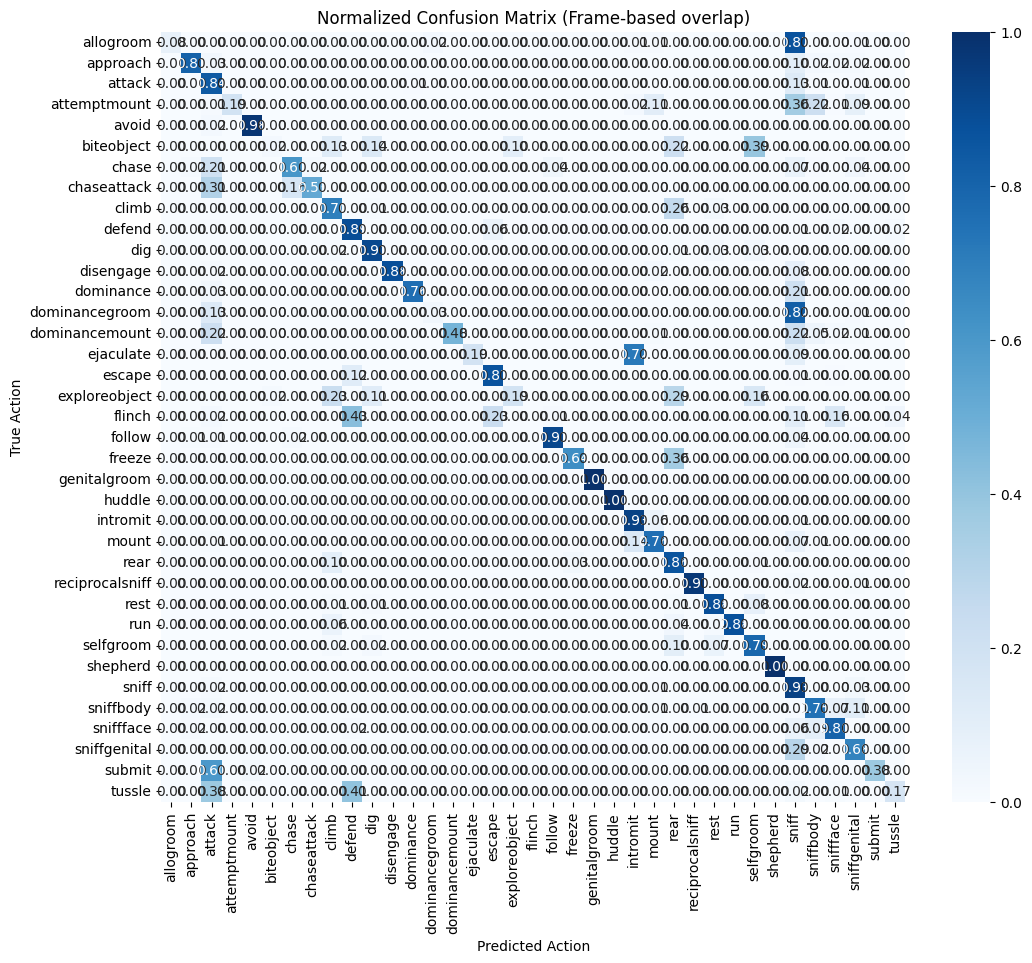


[3] Boundary Precision Analysis:
  - Start Boundary Precision (<= 5 frames): 34.44% (MAE: 77.49 frames)
  - Stop Boundary Precision  (<= 5 frames): 34.99% (MAE: 82.19 frames)
  >>> SUGGESTION: Apply post-processing (dilation/erosion).


In [34]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detailed_error_analysis(solution_df, submission_df, title_prefix=""):
    """
    Thực hiện phân tích lỗi chi tiết: Confusion Matrix, Boundary Precision, Lab Breakdown.
    Đã sửa lỗi KeyError: 'label_key' bằng cách tạo key column trước khi tính toán.
    """
    print(f"--- {title_prefix} DETAILED ERROR ANALYSIS ---")
    
    # --- BƯỚC 1: CHUẨN BỊ DỮ LIỆU CHO METRIC (POLARS + KEYS) ---
    # Chuyển đổi sang Polars
    sol_pl = pl.DataFrame(solution_df)
    sub_pl = pl.DataFrame(submission_df)
    
    # Tạo 'label_key' cho solution: video_id_agent_id_target_id_action
    sol_pl = sol_pl.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('label_key')
    )
    
    # Tạo 'prediction_key' cho submission: video_id_agent_id_target_id_action
    sub_pl = sub_pl.with_columns(
        pl.concat_str(
            [
                pl.col('video_id').cast(pl.Utf8),
                pl.col('agent_id').cast(pl.Utf8),
                pl.col('target_id').cast(pl.Utf8),
                pl.col('action'),
            ],
            separator='_',
        ).alias('prediction_key')
    )

    # ---------------------------------------------------------
    # 1. CROSS-LAB FAILURES (Phân tích lỗi theo từng Lab)
    # ---------------------------------------------------------
    print("\n[1] Cross-lab Performance Breakdown:")
    
    labs = sol_pl['lab_id'].unique().to_list()
    lab_metrics = []
    
    for lab in labs:
        # Lọc dữ liệu của Lab hiện tại (đã có label_key)
        lab_sol = sol_pl.filter(pl.col('lab_id') == lab)
        
        # Lấy danh sách video của lab này để lọc submission tương ứng
        lab_vid = lab_sol['video_id'].unique()
        lab_sub = sub_pl.filter(pl.col('video_id').is_in(lab_vid))
        
        if len(lab_sub) == 0:
            score = 0.0
        else:
            # Gọi hàm single_lab_f1 (lúc này input đã đúng chuẩn có key)
            try:
                score = single_lab_f1(lab_sol, lab_sub)
            except Exception as e:
                print(f"Warning: Error calculating score for lab {lab}: {e}")
                score = 0.0
        
        lab_metrics.append({'lab_id': lab, 'f1_score': score, 'n_videos': len(lab_vid)})
    
    lab_df = pd.DataFrame(lab_metrics).sort_values('f1_score')
    print(lab_df.to_string(index=False))
    
    if not lab_df.empty:
        worst_lab = lab_df.iloc[0]
        print(f"\n>>> Weakest Domain: {worst_lab['lab_id']} (F1: {worst_lab['f1_score']:.4f})")

    # ---------------------------------------------------------
    # 2. CONFUSION MATRIX (Dùng Pandas cho dễ xử lý logic merge)
    # ---------------------------------------------------------
    print("\n[2] Behavior-level Confusion Matrix & Error Types:")
    
    # Lấy danh sách tất cả các behaviors
    all_actions = sorted(list(set(solution_df.action.unique()) | set(submission_df.action.unique())))
    action_to_idx = {a: i for i, a in enumerate(all_actions)}
    
    # Merge để tìm overlap
    merged = pd.merge(
        solution_df[['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']],
        submission_df[['video_id', 'agent_id', 'target_id', 'action', 'start_frame', 'stop_frame']],
        on=['video_id', 'agent_id', 'target_id'],
        how='inner', suffixes=('_gt', '_pred')
    )
    
    # Tính toán overlap frames
    merged['start_overlap'] = merged[['start_frame_gt', 'start_frame_pred']].max(axis=1)
    merged['stop_overlap'] = merged[['stop_frame_gt', 'stop_frame_pred']].min(axis=1)
    merged['overlap_len'] = merged['stop_overlap'] - merged['start_overlap']
    
    valid_overlaps = merged[merged['overlap_len'] > 0].copy()
    
    if len(valid_overlaps) > 0:
        cm = np.zeros((len(all_actions), len(all_actions)), dtype=int)
        
        for _, row in valid_overlaps.iterrows():
            i_gt = action_to_idx[row['action_gt']]
            i_pred = action_to_idx[row['action_pred']]
            cm[i_gt, i_pred] += row['overlap_len']
            
        # Chuẩn hóa CM
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = cm.astype('float') / row_sums
        cm_norm = np.nan_to_num(cm_norm) 

        # Vẽ Plot
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=all_actions, yticklabels=all_actions, cmap='Blues')
        plt.title('Normalized Confusion Matrix (Frame-based overlap)')
        plt.ylabel('True Action')
        plt.xlabel('Predicted Action')
        plt.show()
    else:
        print("No overlapping predictions found to generate Confusion Matrix.")

    # ---------------------------------------------------------
    # 3. BOUNDARY PRECISION
    # ---------------------------------------------------------
    print("\n[3] Boundary Precision Analysis:")
    
    if len(valid_overlaps) > 0:
        tps = valid_overlaps[valid_overlaps['action_gt'] == valid_overlaps['action_pred']].copy()
        
        if len(tps) > 0:
            tps['start_diff'] = (tps['start_frame_pred'] - tps['start_frame_gt']).abs()
            tps['stop_diff'] = (tps['stop_frame_pred'] - tps['stop_frame_gt']).abs()
            
            precision_start = (tps['start_diff'] <= 5).mean() * 100
            precision_stop = (tps['stop_diff'] <= 5).mean() * 100
            mae_start = tps['start_diff'].mean()
            mae_stop = tps['stop_diff'].mean()
            
            print(f"  - Start Boundary Precision (<= 5 frames): {precision_start:.2f}% (MAE: {mae_start:.2f} frames)")
            print(f"  - Stop Boundary Precision  (<= 5 frames): {precision_stop:.2f}% (MAE: {mae_stop:.2f} frames)")
            
            if precision_start < 50 or precision_stop < 50:
                print("  >>> SUGGESTION: Apply post-processing (dilation/erosion).")
        else:
            print("  No True Positives found to analyze boundaries.")
    else:
        print("  No overlaps found.")

# --- GỌI HÀM ---
if CFG.mode == 'validate':
    detailed_error_analysis(solution, submission_robust, title_prefix="VALIDATION")

# Submission

In [35]:
if CFG.mode == 'submit':
    if len(submission_list) > 0:
        submission = pd.concat(submission_list)
    else:
        submission = pd.DataFrame(
            dict(
                video_id=438887472,
                agent_id='mouse1',
                target_id='self',
                action='rear',
                start_frame='278',
                stop_frame='500'
            ), index=[44])
        
    submission_robust = robustify(submission, test, 'test')
    submission_robust.index.name = 'row_id'
    submission_robust.to_csv('submission.csv')
    submission.head()

In [36]:
# import optuna
# import joblib
# import json
# import gc
# import pandas as pd
# import numpy as np
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedGroupKFold
# from sklearn.metrics import f1_score
# import warnings

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# warnings.filterwarnings('ignore')

# def standalone_tuner(mode='single', n_trials=30, sample_size=50000, strategy='balanced'):
    
#     sample_bp_str = body_parts_tracked_list[1]
#     train_subset = train[train.body_parts_tracked == sample_bp_str]
#     bp_list = json.loads(sample_bp_str)
    
#     if len(bp_list) > 5:
#         bp_list = [b for b in bp_list if b not in drop_body_parts]

#     _fps_lookup = (train_subset[['video_id', 'frames_per_second']]
#                    .drop_duplicates('video_id')
#                    .set_index('video_id')['frames_per_second']
#                    .to_dict())

#     X_sample_list = []
#     y_sample_list = []
#     groups_list = []
    
#     print(f"Loading sample data for {mode} mode...")
#     count_rows = 0
    
#     gen_single = (mode == 'single')
#     gen_pair = (mode == 'pair')

#     for switch, data, meta, label in generate_mouse_data(train_subset, 'train', 
#                                                          generate_single=gen_single, 
#                                                          generate_pair=gen_pair):
#         if switch != mode: 
#             continue

#         fps_i = _fps_from_meta(meta, _fps_lookup, default_fps=30.0)
#         if mode == 'single':
#             X_i = transform_single(data, bp_list, fps_i).astype(np.float32)
#         else:
#             X_i = transform_pair(data, bp_list, fps_i).astype(np.float32)
        
#         target_action = None
#         for col in label.columns:
#             if label[col].sum() > 10:
#                 target_action = col
#                 break
        
#         if target_action is None: 
#             del data, meta, label, X_i
#             gc.collect()
#             continue 
            
#         y_i = label[target_action].fillna(0).astype(int)
#         y_i = y_i.reset_index(drop=True)
        
#         X_sample_list.append(X_i)
#         y_sample_list.append(y_i)
#         groups_list.append(meta['video_id'])
        
#         count_rows += len(X_i)
#         del data, meta, label, X_i
#         gc.collect()
        
#         if count_rows >= sample_size:
#             print(f"Loaded {count_rows} rows")
#             break
            
#     if len(X_sample_list) == 0:
#         print("No valid data found")
#         return None

#     X = pd.concat(X_sample_list, ignore_index=True)
#     y = pd.concat(y_sample_list, ignore_index=True).astype(int)
#     groups = pd.concat(groups_list, ignore_index=True)
    
#     del X_sample_list, y_sample_list, groups_list
#     gc.collect()

#     print(f"Dataset: {X.shape}, Positive rate: {y.mean():.3f}, Unique labels: {y.unique()}")
    
#     if len(np.unique(y)) < 2:
#         print("Data have only 1 class. Cannot run.")
#         return None

#     def objective(trial):
#         if strategy == 'deep':
#             # deeper, more complex trees
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 300, 500),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.08, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 7, 10),
#                 'min_child_weight': trial.suggest_int('min_child_weight', 2, 5),
#                 'subsample': trial.suggest_float('subsample', 0.7, 0.9),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0, log=True),
#             }
#         elif strategy == 'fast':
#             # faster, lighter models
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 150, 300),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 4, 6),
#                 'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
#                 'subsample': trial.suggest_float('subsample', 0.7, 0.9),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.85),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 2.0, log=True),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2.0, log=True),
#             }
#         elif strategy == 'regularized':
#             # more regularization to prevent overfitting
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 200, 400),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 5, 7),
#                 'min_child_weight': trial.suggest_int('min_child_weight', 3, 8),
#                 'subsample': trial.suggest_float('subsample', 0.6, 0.85),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.85),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 10.0, log=True),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 10.0, log=True),
#                 'gamma': trial.suggest_float('gamma', 0.1, 1.0),
#             }
#         else:  # 'balanced'
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 200, 400),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, log=True),
#                 'max_depth': trial.suggest_int('max_depth', 5, 8),
#                 'min_child_weight': trial.suggest_int('min_child_weight', 3, 8),
#                 'subsample': trial.suggest_float('subsample', 0.7, 0.9),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 2.0, log=True),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 2.0, log=True),
#             }
        
#         # Fixed params
#         params.update({
#             'tree_method': XGB_TREE_METHOD, 
#             'device': XGB_DEVICE,
#             'verbosity': 0,
#             'random_state': 42,
#         })
        
#         kf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
#         scores = []
        
#         for i, (tr_idx, val_idx) in enumerate(kf.split(X, y, groups=groups)):
#             if i >= 2: break 
            
#             X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
#             y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
            
#             if len(np.unique(y_tr)) < 2:
#                 continue
            
#             model = XGBClassifier(**params)
#             model.fit(X_tr, y_tr, verbose=False)
            
#             try:
#                 y_prob = model.predict_proba(X_val)
#                 if y_prob.shape[1] == 2:
#                     y_pred = (y_prob[:, 1] >= 0.5).astype(int)
#                 else:
#                     y_pred = np.zeros(len(y_val), dtype=int)
#             except Exception:
#                 y_pred = model.predict(X_val).astype(int)
            
#             y_val_int = y_val.astype(int)
            
#             scores.append(f1_score(y_val_int, y_pred, zero_division=0))
            
#             del model
#             gc.collect()
        
#         if len(scores) == 0:
#             return 0.0
            
#         return np.mean(scores)

#     study = optuna.create_study(direction='maximize')
#     study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

#     print(f"\n BEST RESULT FOR {mode.upper()} - {strategy.upper()} (F1: {study.best_value:.4f})")
#     print("\nBest Parameters:")
#     for key, value in study.best_params.items():
#         print(f"  {key}: {value}")
    
#     return study.best_params

# # Chạy lại
# best_params = standalone_tuner(mode='single', n_trials=30, strategy='deep')